# Hsp90

In [1]:
import numpy as np 
import pandas as pd
import os 
from scipy.spatial import distance
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

# Use cryodrgn env
from cryodrgn import utils
from cryodrgn import analysis
from cryodrgn import fft, mrc

import umap

# Graph traversal
from heapq import heappush, heappop
import torch

/home/danlin/anaconda3/envs/cryodrgn/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/danlin/anaconda3/envs/cryodrgn/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/danlin/anaconda3/envs/cryodrgn/lib/python3.10/site-packages/

In [2]:
def get_nearest_point(data, query):
    '''
    Find closest point in @data to @query
    Return index 
    '''
    ind = cdist(query, data).argmin(axis=1)
    return ind

In [3]:
##### MOTIFY THIS PART WHILE DOING OTHER EXPERIMENTS #####
def cal_state_label(x, y):
    '''calculate ground truth labels'''
    label = 20*(x-1)+y
    return label

def get_ground_truth_labels(occ, n_PDs):
    '''
    Calculate ground truth label for each center.
    Since when we create MRC clones are use the order of occ[i][j], 
    the ground truth label would start at CM2 firest. 
    e.g. state_01_01 -> state_01_02 -> ... -> state_05_05 clone 5 times -> ...
    And each MRC would have N PDs images 
    '''
    n_confs = occ.shape[0]**2 # 20x20 CMs in hsp90 experiment
    occ_list = occ.T.flatten().astype(int) # equivalent to occ[i][j]
    ground_truth_labels = np.repeat(np.repeat(np.arange(1,n_confs+1), occ_list), n_PDs)
    return ground_truth_labels

def get_centers_and_path(z, ground_truth_labels):
    '''
    In hsp90 experiment, state1:(5,5), state2(15,16), transition:(15,5)
    '''
    state1 = ground_truth_labels==cal_state_label(5,5)
    state2 = ground_truth_labels==cal_state_label(15,16)
    transition_state = ground_truth_labels==cal_state_label(15,5)

    center1 = get_nearest_point(z, [np.mean(z[state1], axis=0)])[0]
    center2 = get_nearest_point(z, [np.mean(z[state2], axis=0)])[0]
    transition = get_nearest_point(z, [np.mean(z[transition_state], axis=0)])[0]

    path1_label = cal_state_label(np.arange(5,16), 5)
    path1 = []
    for i in path1_label:
        path1.append(get_nearest_point(z, [np.mean(z[ground_truth_labels==i], axis=0)])[0])
    path2_label = cal_state_label(15, np.arange(5,16+1))
    path2 = []
    for i in path2_label:
        path2.append(get_nearest_point(z, [np.mean(z[ground_truth_labels==i], axis=0)])[0])
    truth_path = path1 + path2

    return state1, state2, transition_state, center1, center2, transition, truth_path
#######################################################

# 1. Get the Labels

In this first step, we need to obtain the ground truth labels for the synthetic dataset. Since the images are ordered based on the state they were generated from, we can use this order to create the labels.

For example, the first image in the .mrcs stack would correspond to the first volume with the first projection direction. After 50 projections, the second volume would project 50 images, and so on. These two volumes may represent the same conformational state, as we have created clones for each state based on the occupancy map. The labels we desire should correspond to the states rather than the clones.

**This process can be confusing and may require further clarification for future work.**

In [4]:
workdir =  "/mnt/d/energy_aware_pathfinding/hsp90/"
# load ground trouth occupancy map
occ = np.load(f"{workdir}/noise_occ_1120.npy")
# load training outputs
z = utils.load_pkl(f"{workdir}/z_8/z.49.pkl")

# output dir
pathdir = f"{workdir}/paths"
if not os.path.exists(pathdir):
    os.mkdir(pathdir)

In [5]:
n_PDs = 50
ground_truth_label = get_ground_truth_labels(occ, n_PDs)
state1, state2, transition_state, center1, center2, transition, truth_path = get_centers_and_path(z, ground_truth_label)

# 2. Embedding (densMAP)
The second step of the experiment, which is the visualization of latent space using demsMAP. The [original paper](https://www.nature.com/articles/s41587-020-00801-7) also contains denSNE. However, since the [UMAP library](https://umap-learn.readthedocs.io/en/latest/index.html) already includes the densMAP method, implementing densMAP can be much easier.

To choose the better parameters for densMAP, please refer to the library's website. There are two main parameters for densMAP. First, `dens_frac` is the fraction of epochs to modify the objective function. In other words, if `dens_frac` is not set to 1, only `dens_frac` of the epochs will use the densMAP objective function, while others will use the original UMAP objective function. Second, `dens_lambda` is the magnitude of the correlation of the local radius between the original space and the embedding space (take log). Increasing `dens_lambda` will make the density information more important, which may decrease the visualization performance but retain more density information in the original space.

To my knowledge, the main restriction of implementing densMAP in the UMAP library is that we cannot first train a `umap.fit(x)` and then use `umap.transform(x_new)` for new data points if we set `densMAP=True`. This limitation may affect the usage of the *analyze_landscape(cryoDRGN) pipeline*, which involves training embeddings on some volumes and then transforming them to other randomly sampled volumes.

In [6]:
dens_emb = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    learning_rate=1e-3,
    densmap=True,
    dens_frac=0.7,
    dens_lambda=3,
    random_state=915
).fit_transform(z)

np.save(f'{workdir}/dens_emb.npy', dens_emb)

# 3. Graph Traversal

The default parameters and code are from the cryoDRGN team, which can be found at [here]( https://github.com/zhonge/cryodrgn/blob/master/cryodrgn/commands/graph_traversal.py). Additionally, I have also experimented with using the quantile search approach to choose the threshold instead of `--avg-neighbors` in original graph traversal.

The searching process can be split into 3 steps:
1. Calculate distances for each neighbor (ndist and neighbors).
2. Prune the graph based on the threshold.
3. Apply Dijkstra's algorithm."

In [7]:
# This class can be found at 
# https://github.com/zhonge/cryodrgn/blob/master/cryodrgn/commands/graph_traversal.py

class Graph(object):
    def __init__(self, edges):  # edges is a list of tuples (src, dest, distance)
        # everything after here is derived from (weights, actions, probs)
        # for computational efficiency

        # FIXME: nodes and goal nodes should be the same
        self.nodes = set([x[0] for x in edges] + [x[1] for x in edges])
        self.edges = {x: set() for x in self.nodes}
        self.edge_length = {}
        for s, d, L in edges:
            assert type(s) == int and type(d) == int and type(L) == float
            self.edges[s].add(d)
            self.edge_length[(s, d)] = L

    def find_path(self, src, dest):
        visited = set()
        unvisited = []
        distances = {}
        predecessors = {}

        distances[src] = 0
        heappush(unvisited, (0, src))

        while unvisited:
            # visit the neighbors
            dist, v = heappop(unvisited)
            if v in visited or v not in self.edges:
                continue
            visited.add(v)
            if v == dest:
                # We build the shortest path and display it
                path = []
                pred = v
                while pred is not None:
                    path.append(pred)
                    pred = predecessors.get(pred, None)
                return path[::-1], dist

            neighbors = list(self.edges[v])

            for idx, neighbor in enumerate(neighbors):
                if neighbor not in visited:
                    new_distance = dist + self.edge_length[(v, neighbor)]
                    if new_distance < distances.get(neighbor, float("inf")):
                        distances[neighbor] = new_distance
                        heappush(unvisited, (new_distance, neighbor))
                        predecessors[neighbor] = v
            
        # couldn't find a path
        return None, None

In [8]:
def construct_grpah(z, max_neighbors, use_cuda=True):
    '''
    constrcut a knn graph from latent variables
    '''
    data = torch.from_numpy(z)
    if use_cuda:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu") 
    data = data.to(device)

    N, D = data.shape
    B = 5000 # batch size, set to lower value if GPU memory limit.
    n2 = (data * data).sum(-1, keepdim=True)

    ndist = torch.empty(data.shape[0], max_neighbors, device=device)
    neighbors = torch.empty(
        data.shape[0], max_neighbors, dtype=torch.long, device=device
    )

    for i in range(0, data.shape[0], B):
        # (a-b)^2 = a^2 + b^2 - 2ab
        #print(f"Working on images {i}-{i+B}")
        batch_dist = n2[i : i + B] + n2.t() - 2 * torch.mm(data[i : i + B], data.t())
        ndist[i : i + B], neighbors[i : i + B] = batch_dist.topk(
            max_neighbors, dim=-1, largest=False
        )

    ndist = ndist.clamp(min=0).pow(0.5)
    return ndist, neighbors

def default_graph_travseral(ndist, neighbors, anchors, pathdir):
    '''
    perform graph traversal in default parameters, 
    searhing through anchors(a list of data points index)
    '''
    # pruning the graph
    N = neighbors.shape[0]
    avg_neighbors = 5
    total_neighbors = int(N * avg_neighbors)
    max_dist = ndist.view(-1).topk(total_neighbors, largest=False)[0][-1]

    max_dist = max_dist.to("cpu")
    neighbors = neighbors.to("cpu")
    ndist = ndist.to("cpu")

    edges = []
    for i in range(neighbors.shape[0]):
        for j in range(neighbors.shape[1]):
            if max_dist is None or ndist[i, j] < max_dist:
                edges.append((int(i), int(neighbors[i, j]), float(ndist[i,j])))

    # searching
    graph = Graph(edges)
    full_path = []
    for i in range(len(anchors)-1):
        src, dest = anchors[i], anchors[i+1]
        path, _ = graph.find_path(src, dest)
        
        if path is not None:
            if full_path and full_path[-1] == path[0]:
                full_path.extend(path[1:])
            else:
                full_path.extend(path)
        else: 
            full_path.append(None)
    
    # save the results
    np.savetxt(f'{pathdir}/default.txt', full_path)
    return full_path

In [9]:
ndist, neighbors = construct_grpah(z, max_neighbors=10)
default_gt = default_graph_travseral(ndist, neighbors, anchors=[center1, center2], pathdir=pathdir)

## GT-q

In [10]:
def euclidean_weights_searching(ndist, neighbors, quantile_list, anchors):
    '''
    Try to searching the threshold for a given knn graph in graph traversal framework
    '''
    path_list = []
    for q in quantile_list:
        #print(f'Working on quantile={q}')   
        # pruning 
        max_dist = torch.quantile(ndist, q=q)
        max_dist = max_dist.to("cpu")
        neighbors = neighbors.to("cpu")
        ndist = ndist.to("cpu")

        edges = []
        for i in range(neighbors.shape[0]):
            for j in range(neighbors.shape[1]):
                if max_dist is None or ndist[i, j] < max_dist:
                    edges.append((int(i), int(neighbors[i, j]), float(ndist[i,j])))

        # searching
        graph = Graph(edges)
        full_path = []
        for i in range(len(anchors)-1):
            src, dest = anchors[i], anchors[i+1]
            path, _ = graph.find_path(src, dest)
            
            if path is not None:
                if full_path and full_path[-1] == path[0]:
                    full_path.extend(path[1:])
                else:
                    full_path.extend(path)
            else: 
                full_path.append(None)
        path_list.append(full_path)

    return path_list

def plot_searching_results(emb, labels, centers, paths, quantile_list):
    '''
    plot the euclidean threshold searching results
    '''
    state_legend = ["State1", "State2", "Transition state"]
    plt.figure(figsize=(15,15))
    plt.scatter(emb[:,0], emb[:,1], s=0.5, alpha=0.5)
    for i, state in enumerate(labels):
        plt.scatter(emb[state][:,0], emb[state][:,1], s=5, label=f"{state_legend[i]}", zorder=1)

    cmap = plt.cm.get_cmap('tab20b')
    for i, path in enumerate(paths):
        if None in path:
            print(f"q={quantile_list[i]}  can not find the path")
        else:
            color = cmap(i/(len(quantile_list)-1))
            plt.plot(emb[path][:,0], emb[path][:,1], '-o', 
                     markersize=5, color=color,label=f"q={quantile_list[i]}")
            
    plt.scatter(emb[centers][:,0], emb[centers][:,1], s=10, c='w', zorder=3)
    plt.legend()
    plt.show()

def save_the_best_threshold(ndist, paths, quantile_list, pathdir, eng=False, plot=True):
    '''
    Save the best threshold based on the average distance metric
    for the output path p_1, p_2, ..., p_q and its neighbors p_j (N is the number of negibhors)
    (1/q)\sum_{i=1}^q(\sum_{j}||p_i-p_j||/N)
    '''
    metric_ = []
    for i, path in enumerate(paths):
        if None in path:
            metric_.append(None)
        else:
            max_dist = torch.quantile(ndist, quantile_list[i])
            mean_below_threshold = (ndist * (ndist < max_dist).float()).sum(dim=1) / (ndist < max_dist).sum(dim=1).clamp(min=1)
            metric_.append(torch.mean(mean_below_threshold[path]).to("cpu"))

    # save the lowest
    metric = [x for x in metric_ if x is not None]
    min_index = metric_.index(min(metric))
    if eng:
        np.savetxt(f'{pathdir}/eng.txt', paths[min_index])
    else:
        np.savetxt(f'{pathdir}/quantile.txt', paths[min_index])

    # plot
    if plot:
        plt.plot(quantile_list, metric_, "-o")
        plt.xlabel('quantile')
        plt.ylabel('mean of avg_dist')
        plt.show

In [11]:
ndist, neighbors = construct_grpah(z, max_neighbors=10)
toy_quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
toy_paths = euclidean_weights_searching(ndist, neighbors, 
                                       quantile_list=toy_quantiles, anchors=[center1, center2])

/tmp/ipykernel_3367/2461043145.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b')


q=0.1  can not find the path


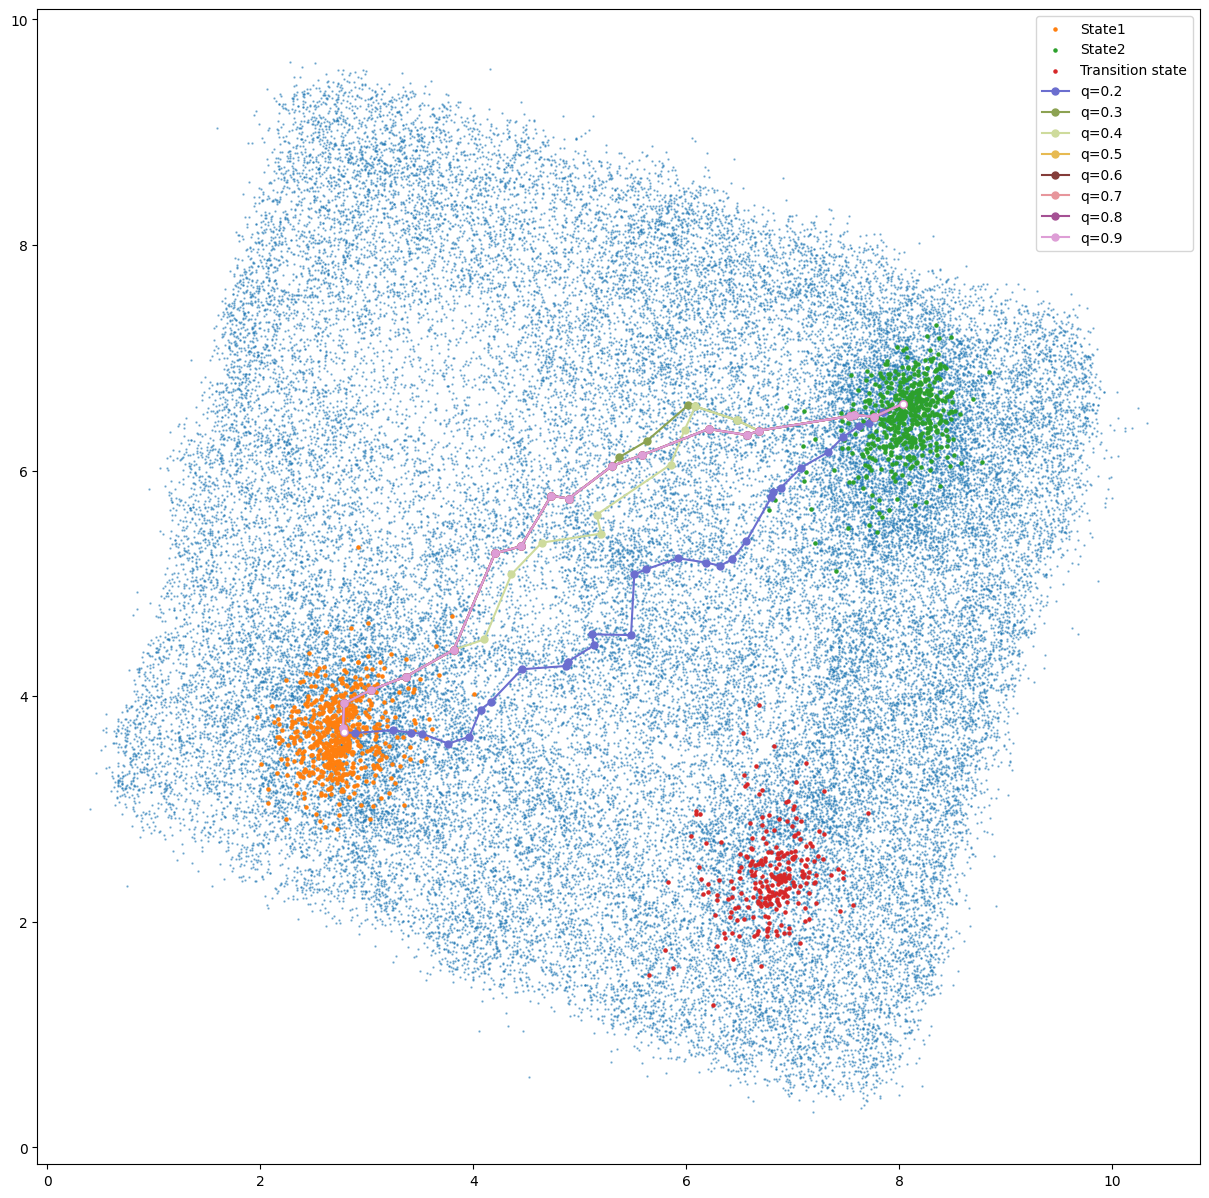

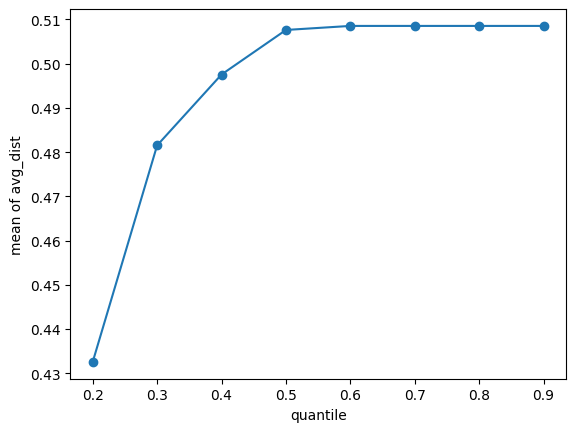

In [12]:
plot_searching_results(emb=dens_emb, 
                       labels=[state1, state2, transition_state], 
                       centers=[center1, center2, transition],
                       paths=toy_paths,
                       quantile_list=toy_quantiles)

save_the_best_threshold(ndist, toy_paths, toy_quantiles, pathdir=pathdir, eng=False, plot=True)

# 4. Our method
Our method is based on graph traversal with redefined edge weights using an energy-aware value.

The main modification in our method is that for each threshold (quantile), we estimate the free energy based on `ndist` and control the landscape shape by considering the zero energy ratio of the entire graph. If the zero energy ratio for a given threshold falls outside the range of $(r_l, r_u)$, we do not apply Dijkstra's algorithm.

In [13]:
def energy_weights_searching(ndist, neighbors, quantile_list, anchors, lowest_ratio=0.01, highest_ratio=0.1):
    '''
    Defined the edge weights as free-energy
    '''
    path_list = []
    N, max_neighbors = neighbors.shape
    for q in quantile_list:
        max_dist = torch.quantile(ndist, q=q)
        # calculate free energy = -log(n_i/n_max)
        grids_counts = (ndist <= max_dist).sum(dim=1)
        eng = -torch.log(grids_counts/grids_counts.max())
        eng[eng==-0.] = 0.

        # control the the ratio of zero energy 
        states, counts = torch.unique(eng, return_counts=True)
        zero_energy_ratio = counts[0]/N
        if states.shape[0] <2 or zero_energy_ratio>highest_ratio or zero_energy_ratio<lowest_ratio:
            print(f'q={q} are not suitable.')
            path_list.append([None])

        else:
            neighbors = neighbors.to("cpu")
            ndist = ndist.to("cpu")
            eng = eng.to("cpu")

            eng_dist = torch.empty(N, max_neighbors, dtype=eng.dtype)
            for i in range(N):
                # get the indices of the neighbors for the current point
                neighbor_indices = neighbors[i]
                # use the indices to retrieve the values of the neighbors from the value vector
                eng_dist[i] = (eng[neighbor_indices]+eng[i])/2.
            eng_dist = eng_dist.to("cpu")

            edges_eng = []
            for i in range(neighbors.shape[0]):
                for j in range(neighbors.shape[1]):
                    edges_eng.append((int(i), int(neighbors[i, j]), float(eng_dist[i,j])))

            # searching
            graph = Graph(edges_eng)
            full_path = []
            for i in range(len(anchors)-1):
                src, dest = anchors[i], anchors[i+1]
                path, _ = graph.find_path(src, dest)
                
                if path is not None:
                    if full_path and full_path[-1] == path[0]:
                        full_path.extend(path[1:])
                    else:
                        full_path.extend(path)
                else: 
                    full_path.append([None])
            path_list.append(full_path)
    return path_list


In [14]:
ndist, neighbors = construct_grpah(z, max_neighbors=50)
toy_quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
toy_paths = energy_weights_searching(ndist, neighbors, 
                                     quantile_list=toy_quantiles, anchors=[center1, center2])

q=0.1 are not suitable.
q=0.4 are not suitable.
q=0.5 are not suitable.
q=0.6 are not suitable.
q=0.7 are not suitable.
q=0.8 are not suitable.
q=0.9 are not suitable.


/tmp/ipykernel_3367/2461043145.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b')


q=0.1  can not find the path
q=0.4  can not find the path
q=0.5  can not find the path
q=0.6  can not find the path
q=0.7  can not find the path
q=0.8  can not find the path
q=0.9  can not find the path


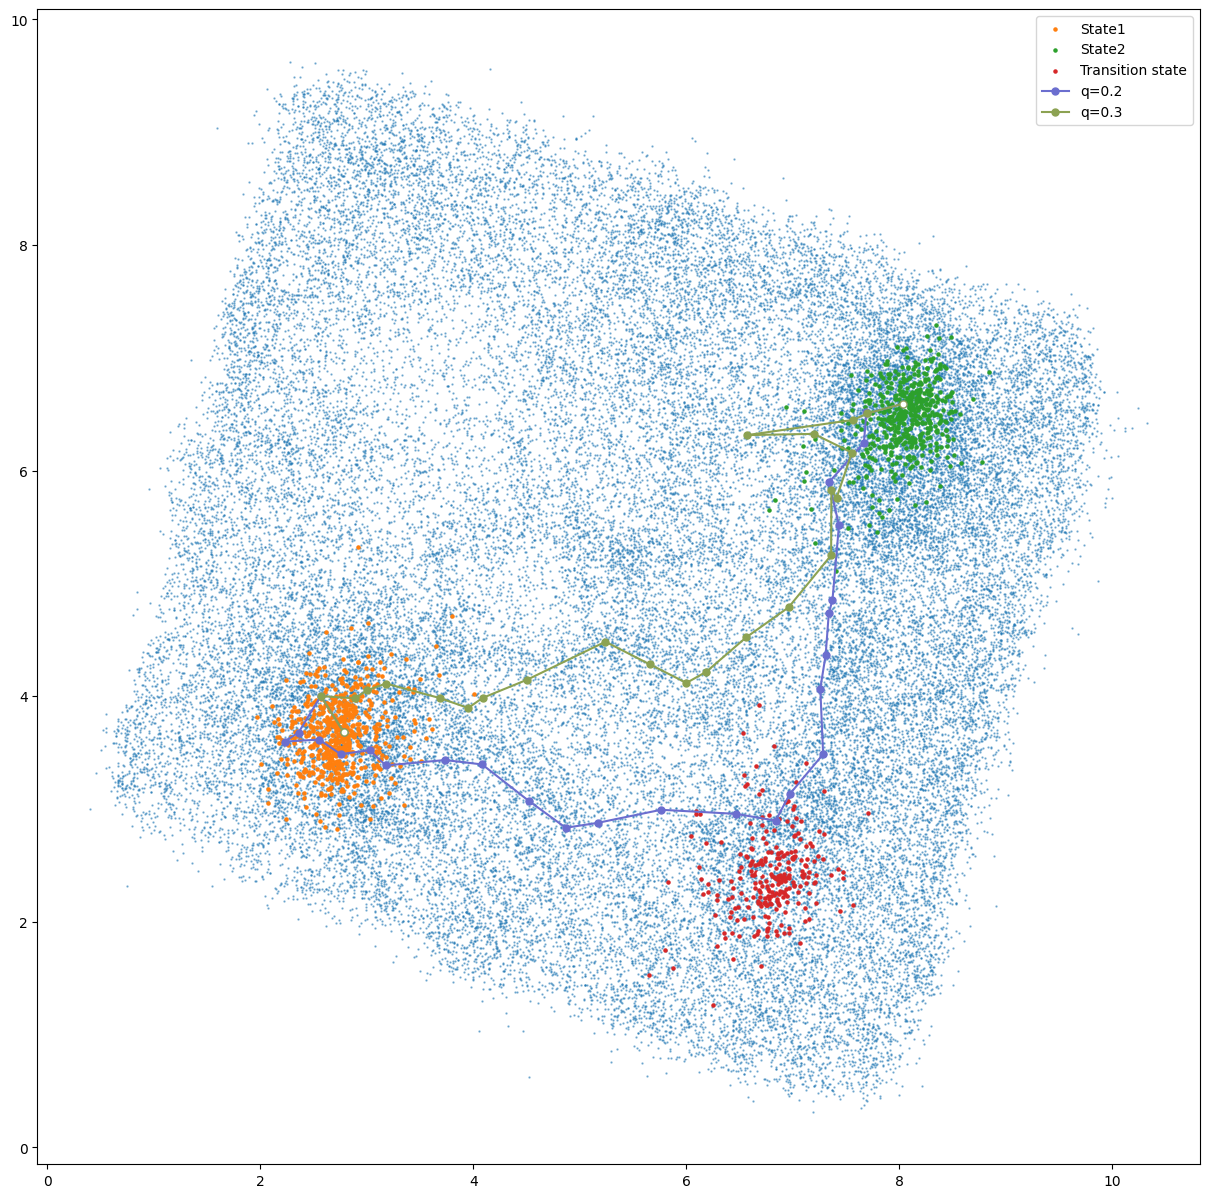

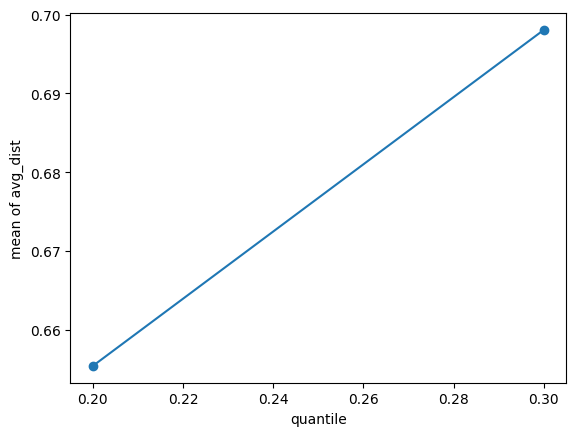

In [15]:
plot_searching_results(emb=dens_emb, 
                       labels=[state1, state2, transition_state], 
                       centers=[center1, center2, transition],
                       paths=toy_paths,
                       quantile_list=toy_quantiles)

save_the_best_threshold(ndist, toy_paths, toy_quantiles, pathdir=pathdir, eng=True, plot=True)

# Implement POLARIS
The implementation of POLARIS for cryoDRGN latent space can be divided into three steps:

1. Conversion to a 2D energy landscape.
2. Application of POLARIS.
3. Conversion back to data point indices.

Since we are searching for the minimum energy path (MEP) in the 2D energy landscape rather than the original space with indices, the output of POLARIS represents the path located in the 2D energy landscape. However, when we want to compare FSC, we need the data point indices (or latent space values) to generate the 3D volume using the cryoDRGN decoder. In my experiment, I use the center point of the grid cell in the 2D landscape as the reference point for generating the 3D volume, for the sake of simplicity. 

This approach can be further modified in future work, for example, by considering the average latent value within the grid cell or exploring other modifications to improve the quality of the generated 3D volume. However, it is important to note that the accuracy of the embedding space plays a crucial role in the workflow of densMAP+POLARIS. This limitation is discussed further in the appendix of the thesis.

## Setup [POLARIS](https://github.com/evanseitz/POLARIS)
Here, I will briefly go through the process of setting up POLARIS in WSL2. I tested it on Windows and Mac (M1), but it doesn't work. Make sure to use a Linux environment (or WSL) if you want to follow the setup guide.

1. Create a empty conda env.
```shell
    conda create --no-default-packages -n polaris python=3.7
```
2. Install packages.
```shell
    pip install --upgrade pip
    pip install PyQt5
    pip install matplotlib
    conda install -c anaconda psutil
```
3. `git clone https://github.com/evanseitz/POLARIS.git`

During my testing, I encountered some issues when using a newer version of Python, such as 3.9. Additionally, the environment file from GitHub did not work, so I followed the README guide to create an empty environment. Also, if I remember correctly, make sure to add a \ on line 969 inside POLARIS_GUI.py if you clone [the repository from GitHub](https://github.com/evanseitz/POLARIS/blob/9790254ed49c1ea8279e95fd3c57b163baaf550a/POLARIS_GUI.py#L969).

## Convert to 2D energy landsacpe

In [16]:
def free_energy(emb, n_states):
    '''
    Convert to energy landscape based on bins-count appraoch.
    '''
    n_cells_x = np.linspace(emb[:,0].min(), emb[:,0].max(), n_states+1)
    n_cells_y = np.linspace(emb[:,0].min(), emb[:,1].max(), n_states+1)
    n_bins = [n_cells_x, n_cells_y]
    grids, edges = np.histogramdd(emb,  bins=n_bins)
    grids = grids.T
    #energy
    occmax = np.amax(grids)
    E = -np.log(grids/occmax)
    E[E==np.inf] = np.unique(E)[-2] + 0.00001 # replace -inf to second lowest energy plus constant.
    return E

def points_for_polaris(emb, n_states, list_idx):
    '''
    Convert the starting and ending point index in to the location in 2D energy landscape.
    '''
    x = emb[:,0][list_idx]
    y = emb[:,1][list_idx]
    n_cells_x = np.linspace(emb[:,0].min(), emb[:,0].max(), n_states+1)
    n_cells_y = np.linspace(emb[:,1].min(), emb[:,1].max(), n_states+1)
    x = np.digitize(x, n_cells_x)
    y = np.digitize(y, n_cells_y)
    start = np.stack((x,y), axis=1)[0,:]
    end = np.stack((x,y), axis=1)[1,:]
    return print(f"Start:{start}", f"End:{end}")

/tmp/ipykernel_3367/1056122399.py:12: RuntimeWarning: divide by zero encountered in log
  E = -np.log(grids/occmax)


Start:[15 22] End:[47 41]


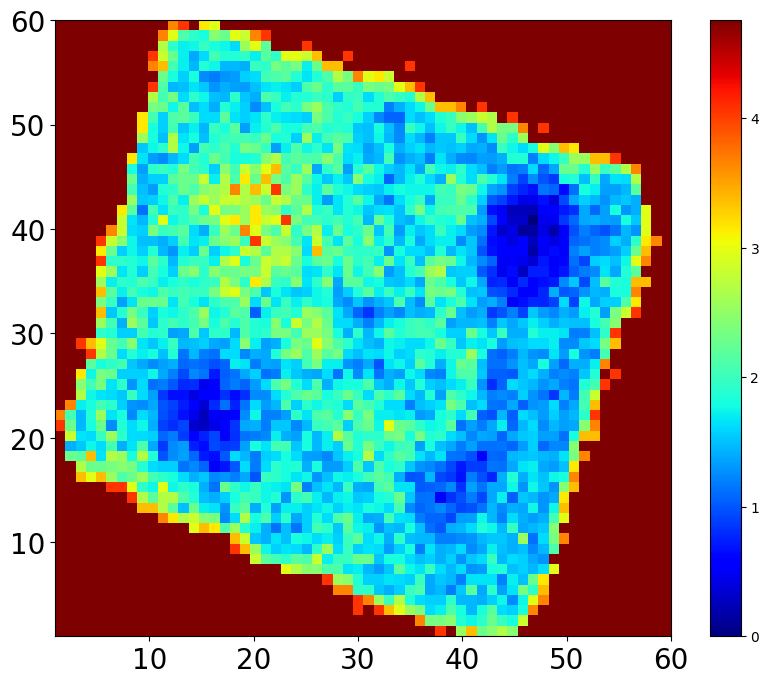

In [17]:
# load densMAP result
dens_emb = np.load(f'{workdir}/dens_emb.npy')
# output dir for 2D energy landsacpe
engdir = "/home/danlin/POLARIS/data_input/"

eng = free_energy(dens_emb, n_states=60)
plt.figure(figsize=(10,8))
plt.imshow(eng, origin='lower', extent=[1,60,1,60], cmap='jet')
plt.colorbar()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

np.savetxt(f'{engdir}/hsp90.txt', eng)
points_for_polaris(dens_emb, n_states=60, list_idx=[center1, center2])

## After searching

In [18]:
def save_polaris_result(emb, path, pathdir, n_states=60):
    ''' 
    After searching MEP using POLARIS, convert the path location in 2D back to data point index
    '''
    polaris_result = path[:,:2].astype(int)
    # energy coordiante -> embedding space coordinate
    n_cells_x = np.linspace(emb[:,0].min(), emb[:,0].max(), n_states+1)
    n_cells_y = np.linspace(emb[:,1].min(), emb[:,1].max(), n_states+1)
    polaris_2d = np.stack((n_cells_x[polaris_result[:,0]] , n_cells_y[polaris_result[:,1]])).T
    # embedding space coordinate -> nearest point index 
    polaris_path = get_nearest_point(emb, polaris_2d)
    np.savetxt(f'{pathdir}/polaris.txt', polaris_path)

In [19]:
polaris_result = np.loadtxt(f'{workdir}/polaris/polaris_output.txt', skiprows=9, usecols=(0, 1)) #only keep x and y coodrinate
save_polaris_result(emb=dens_emb, path=polaris_result, pathdir=pathdir, n_states=60)

# Comparsion and Evaulation
First, we generate a 3D volume following the tutorial from cryoDRGN using cryodrgn.analyze. Once the generation is complete, [we calculate the FSC using the same code from cryoDRGN](https://github.com/zhonge/cryodrgn/blob/master/analysis_scripts/fsc.py). Additionally, we evaluate three approaches based on the distance to the ground truth center in the latent space.

In [20]:
# Load results
z = utils.load_pkl(f'{workdir}/z_8/z.49.pkl')
dens_emb = np.load(f'{workdir}/dens_emb.npy')

default_path = np.loadtxt(f'{workdir}/paths/default.txt').astype(int)
quantile_path = np.loadtxt(f'{workdir}/paths/quantile.txt').astype(int)
eng_path = np.loadtxt(f'{workdir}/paths/eng.txt').astype(int)
polaris_path = np.loadtxt(f'{workdir}/paths/polaris.txt').astype(int)

## Viz

In [21]:
def plot_results(emb, labels, centers, paths):
    '''
    plot the embedding results with the color of each conformational state 
    and the center of each state(black dpt).
    '''
    state_legend = ["Start", "End", "Transition state"]
    state_colors = ['tab:orange', 'tab:green', 'tab:red']
    path_legend = ["Ground truth label centers", 
                "Graph traversal", 
                "Graph traversal (quantile search)", 
                "Our method ", 
                "Searching on 2D energy landscape"]
    path_colors= ['k', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

    plt.figure(figsize=(10, 8))
    plt.scatter(emb[:, 0], emb[:, 1], s=0.5, alpha=0.25) #densMAP
    for i, state in enumerate(labels):
        plt.scatter(emb[state][:, 0], emb[state][:, 1], s=2, alpha=0.5, c=state_colors[i], zorder=1) #states

    for i, path in enumerate(paths):
        plt.plot(
            emb[path][:, 0], emb[path][:, 1], '-o',
            markersize=5, c=path_colors[i], zorder=2
        ) #paths

    plt.scatter(emb[centers][:, 0], emb[centers][:, 1], s=1, c='w', zorder=3) #white dot for three centers
    plt.xlabel("densMAP 1", fontsize=20)
    plt.ylabel("densMAP 2", fontsize=20)
    plt.show()

    # legend plot
    fig_legend_combined = plt.figure(figsize=(5, 3))  
    axi = fig_legend_combined.add_subplot(111)
    axi.axis('off')
    lines_states = [plt.Line2D([0], [0], color=c, marker='o', linestyle='', markersize=10) for c in state_colors]
    lines_paths = [plt.Line2D([0], [0], color=c, linewidth=2, marker='o', markersize=10) for c in path_colors] 
    combined_lines = lines_states + lines_paths
    combined_labels = state_legend + path_legend
    fig_legend_combined.legend(combined_lines, combined_labels, fontsize=20, loc='center')
    plt.show()

def closest_to_transition(z, path, transition_idx):
    '''
    Find the point in the path which is closest to the transtion state center
    '''
    nearest_point = None
    nearest_distance = float('inf')
    for indx, points in enumerate(z[path]):
        d = distance.euclidean(z[transition_idx], points)
        if d < nearest_distance:
            nearest_point = indx
            nearest_distance = d
    return path[nearest_point], nearest_distance

def plot_cloest_point(emb, points_list):
    '''
    Plot the cloest point with transition state center in embedding space
    '''
    color_list = ['k', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    plt.figure(figsize=(10,8))
    plt.scatter(emb[:,0], emb[:,1], s=0.01)
    for i, point in enumerate(points_list):
        plt.scatter(emb[point, 0], emb[point, 1], s=100, c=color_list[i])
    plt.xlabel("densMAP 1", fontsize=20)
    plt.ylabel("densMAP 2", fontsize=20)
    plt.show()

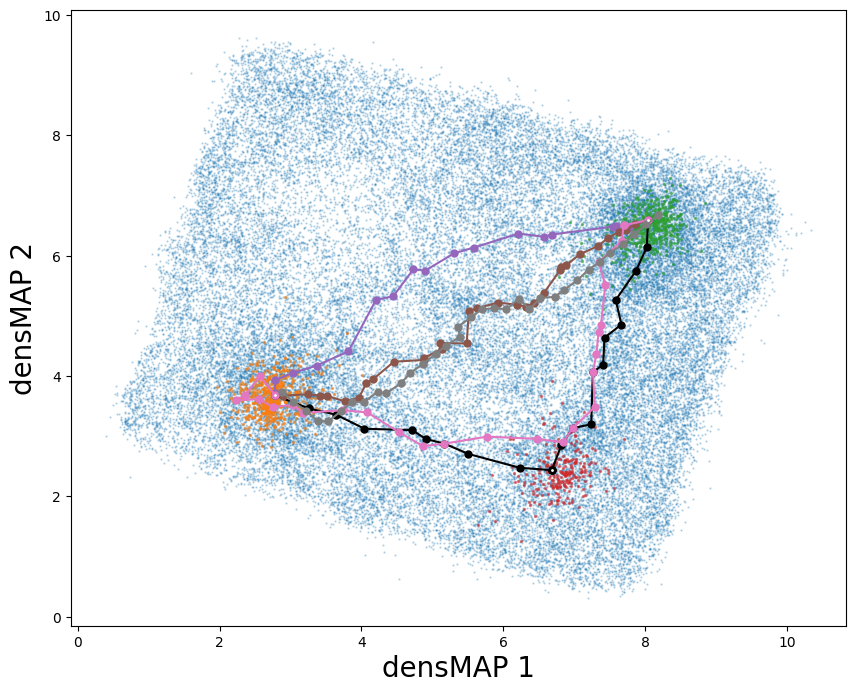

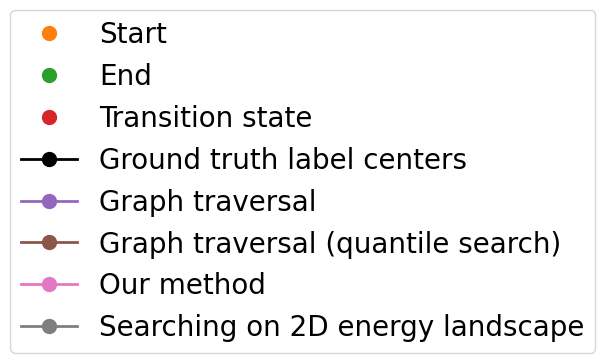

In [22]:
n_PDs = 50
ground_truth_label = get_ground_truth_labels(occ, n_PDs)
state1, state2, transition_state, center1, center2, transition, truth_path = get_centers_and_path(z, ground_truth_label)

plot_results(emb=dens_emb,
             labels=[state1, state2, transition_state],
             centers=[center1, center2, transition],
             paths=[truth_path, default_path, quantile_path, eng_path, polaris_path])

Default 3.8514771461486816 Quantile 2.907313823699951 Energy 0.8969053626060486 POLARIS 2.729128360748291


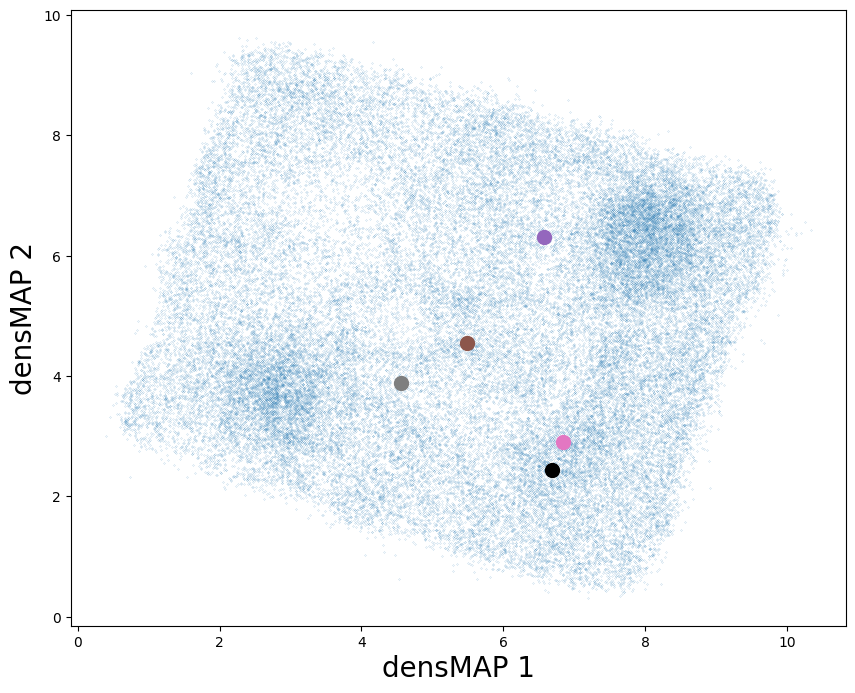

In [23]:
default_vol_idx, default_d = closest_to_transition(z, default_path, transition)
quantile_vol_idx, quantile_d = closest_to_transition(z, quantile_path, transition)
eng_vol_idx, eng_d = closest_to_transition(z, eng_path, transition)
polaris_vol_idx, polaris_d = closest_to_transition(z, polaris_path, transition)
print("Default",default_d, "Quantile",quantile_d, "Energy",eng_d, "POLARIS", polaris_d)
plot_cloest_point(
    dens_emb, 
    [transition, default_vol_idx, quantile_vol_idx, eng_vol_idx, polaris_vol_idx]
)

## FSC

In [24]:
def generate_volumes(zvalues, zdir, outdir, **kwargs):
    '''
    Helper function to call cryodrgn eval_vol and generate new volumes
    '''
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    np.savetxt(f'{outdir}/zfile.txt', zvalues)
    analysis.gen_volumes(weights=f'{zdir}/weights.49.pkl',
                         config=f'{zdir}/config.pkl',
                         zfile=f'{outdir}/zfile.txt',
                         outdir=f'{outdir}', **kwargs)
    return print(f'vol in {outdir}/')

def cal_fsc(vol1, vol2):
    '''
    Calculate fsc.
    (From cryoDRGN)
    '''
    D = vol1.shape[0]
    x = np.arange(-D // 2, D // 2)
    x2, x1, x0 = np.meshgrid(x, x, x, indexing="ij")
    coords = np.stack((x0, x1, x2), -1)
    r = (coords**2).sum(-1) ** 0.5

    assert r[D // 2, D // 2, D // 2] == 0.0

    vol1 = fft.fftn_center(vol1)
    vol2 = fft.fftn_center(vol2)

    prev_mask = np.zeros((D, D, D), dtype=bool)
    fsc = [1.0]
    for i in range(1, D // 2):
        mask = r < i
        shell = np.where(mask & np.logical_not(prev_mask))
        v1 = vol1[shell]
        v2 = vol2[shell]
        p = np.vdot(v1, v2) / (np.vdot(v1, v1) * np.vdot(v2, v2)) ** 0.5
        fsc.append(float(p.real))
        prev_mask = mask
    fsc = np.asarray(fsc)
    x = np.arange(D // 2) / D

    res = np.stack((x, fsc), 1)
    return res

def cal_resolution(fsc, threshold=0.5):
    idx = np.abs(fsc[:,1] - threshold).argmin()
    return 1/fsc[idx,0]

def plot_fsc_comparsion(x, fsc_list):
    plt.figure(figsize=(10,8))
    color_list = ['k', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    for i, fsc in enumerate(fsc_list):
        plt.plot(x, fsc, c=color_list[i])
    plt.axvline(x = 0.1, color = 'k', linestyle = '--')
    plt.xlabel("Frequency", fontsize=20)
    plt.ylabel("FSC", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

In [25]:
generate_volumes(zvalues=z[[transition, default_vol_idx, quantile_vol_idx, eng_vol_idx, polaris_vol_idx]],
                 zdir=f'{workdir}/z_8',
                 outdir=f'{workdir}/vols/',
                 Apix = 1)

(INFO) (eval_vol.py) (09-Aug-23 08:58:25) Use cuda True
(INFO) (eval_vol.py) (09-Aug-23 08:58:25) Namespace(weights='/mnt/d/Energy_graph_searching/hsp90//z_8/weights.49.pkl', config='/mnt/d/Energy_graph_searching/hsp90//z_8/config.pkl', o='/mnt/d/Energy_graph_searching/hsp90/vols', device=None, prefix='vol_', verbose=False, z=None, z_start=None, z_end=None, n=10, zfile='/mnt/d/Energy_graph_searching/hsp90//vols//zfile.txt', Apix=1.0, flip=False, invert=False, downsample=None, vol_start_index=0, norm=None, D=None, qlayers=None, qdim=None, zdim=None, encode_mode=None, players=None, pdim=None, enc_mask=None, pe_type=None, feat_sigma=None, pe_dim=None, domain=None, l_extent=None, activation='relu')
(INFO) (eval_vol.py) (09-Aug-23 08:58:25) Loaded configuration:


{'dataset_args': {'ctf': '/home/danlin/hsp90/more_rmsd/ctf.pkl',
                  'datadir': None,
                  'do_pose_sgd': False,
                  'ind': None,
                  'invert_data': True,
                  'keepreal': False,
                  'norm': [0, 105.96209],
                  'particles': '/home/danlin/hsp90/more_rmsd/hsp90_50PDs_SNR01.mrcs',
                  'poses': '/home/danlin/hsp90/more_rmsd/poses.pkl',
                  'window': True,
                  'window_r': 0.85},
 'lattice_args': {'D': 129, 'extent': 0.5, 'ignore_DC': True},
 'model_args': {'activation': 'relu',
                'domain': 'fourier',
                'enc_mask': 64,
                'encode_mode': 'resid',
                'feat_sigma': 0.5,
                'pdim': 256,
                'pe_dim': None,
                'pe_type': 'gaussian',
                'players': 3,
                'qdim': 256,
                'qlayers': 3,
                'zdim': 8},
 'seed': 80735}
(INFO) 

/home/danlin/anaconda3/envs/cryodrgn/lib/python3.10/site-packages/cryodrgn/config.py:14: UserWarning: Loading configuration from a .pkl file is deprecated. Please save/load configurationas a .yaml file instead.
  warnings.warn(


(INFO) (eval_vol.py) (09-Aug-23 08:58:26) [ 0.87483817 -0.03213063  0.75459898 -0.21885023 -0.92040473  1.12548733
  0.24904709  0.0976818 ]
(INFO) (eval_vol.py) (09-Aug-23 08:58:26) [ 0.51721328 -0.43259817 -0.71259815 -0.76146114 -0.12460271  0.71942073
  0.19992898 -1.1209203 ]
(INFO) (eval_vol.py) (09-Aug-23 08:58:27) [-0.4861781  -0.10059753 -0.72961736 -0.1741502  -1.32542682 -0.42198256
 -1.28804803 -1.62959409]
(INFO) (eval_vol.py) (09-Aug-23 08:58:27) [ 0.1410943  -0.37778533 -0.8118751  -0.90310675  0.53551948 -0.18695249
  0.28522587 -1.59873891]
(INFO) (eval_vol.py) (09-Aug-23 08:58:28) Finished in 0:00:03.280975
vol in /mnt/d/Energy_graph_searching/hsp90//vols//


In [26]:
vol_truth, _ = mrc.parse_mrc(f'{workdir}/vols/state_15_05_1.mrc')
vol_center, _ = mrc.parse_mrc(f'{workdir}/vols/vol_000.mrc')
vol_default, _ = mrc.parse_mrc(f'{workdir}/vols/vol_001.mrc')
vol_quantile, _ = mrc.parse_mrc(f'{workdir}/vols/vol_002.mrc')
vol_eng, _ = mrc.parse_mrc(f'{workdir}/vols/vol_003.mrc')
vol_polaris, _ = mrc.parse_mrc(f'{workdir}/vols/vol_004.mrc')

fsc_center = cal_fsc(vol_truth, vol_center)
fsc_default = cal_fsc(vol_truth, vol_default)
fsc_quantile = cal_fsc(vol_truth, vol_quantile)
fsc_eng = cal_fsc(vol_truth, vol_eng)
fsc_polaris = cal_fsc(vol_truth, vol_polaris)

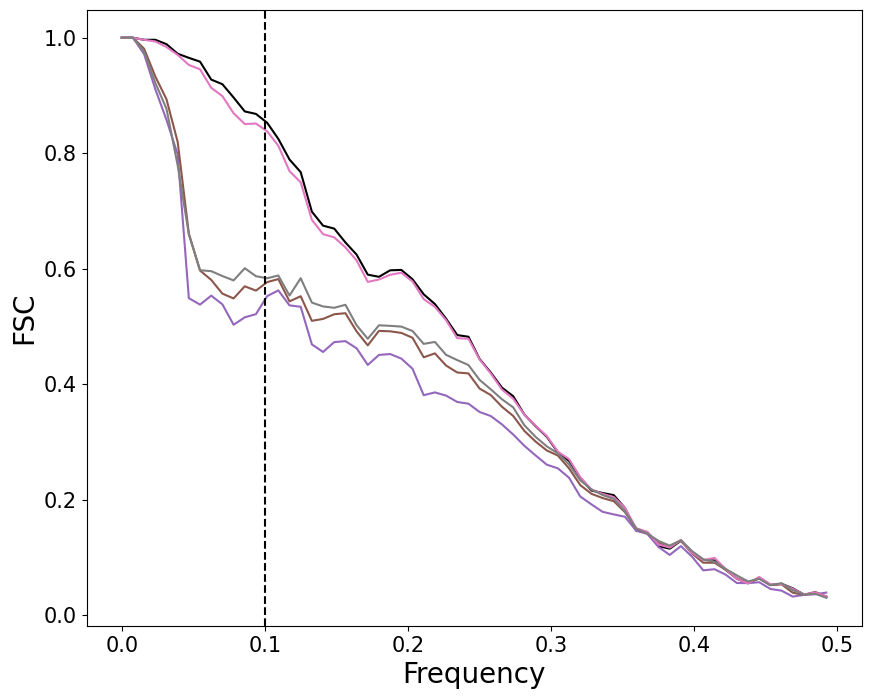

In [27]:
plot_fsc_comparsion(x=fsc_center[:,0],
                    fsc_list=[fsc_center[:,1], fsc_default[:,1], fsc_quantile[:,1], fsc_eng[:,1], fsc_polaris[:,1]])

In [28]:
print("Label center:", fsc_center[13,1])
print("GT:", fsc_default[13,1])
print("GT-q:", fsc_quantile[13,1])
print("MEP(2D):", fsc_polaris[13,1])
print("Our:", fsc_eng[13,1])

Label center: 0.8527586278801669
GT: 0.5524777267348095
GT-q: 0.5767009100662174
MEP(2D): 0.5833488166230572
Our: 0.8380116167365671


## Distances

In [29]:
def ave_distance(z, truth, path):
    dis = []
    for i in truth:
        _, d = closest_to_transition(z, path, i)
        dis.append(d)
    return sum(dis)/(len(truth)-2)
    
def sum_distance(z, truth, path):
    dis = []
    for i in truth:
        _, d = closest_to_transition(z, path, i)
        dis.append(d)
    return sum(dis)

def hausdorff_distance(set1, set2):
  # Initialize maximum distance to 0
  max_distance_1 = 0
  
  # Iterate through points in set1
  for point1 in set1:
    # Find nearest point in set2
    nearest_point = None
    nearest_distance = float('inf')
    for point2 in set2:
      d = distance.euclidean(point1, point2)
      if d < nearest_distance:
        nearest_point = point2
        nearest_distance = d
    # Update maximum distance if necessary
    max_distance_1 = max(max_distance_1, nearest_distance)
  
  max_distance_2 = 0

  for point2 in set2:
    nearest_point = None
    nearest_distance = float('inf')

    for point1 in set1:
      d = distance.euclidean(point1, point2)
      if d < nearest_distance:
        nearest_point = point1
        nearest_distance = d
    
    max_distance_2 = max(max_distance_2, nearest_distance)

  max_distance = max(max_distance_1, max_distance_2)
  return max_distance

In [30]:
print("GT:",ave_distance(z, truth_path, default_path))
print("GT-q:",ave_distance(z, truth_path, quantile_path))
print("MEP(2D):",ave_distance(z, truth_path, polaris_path))
print("Our:",ave_distance(z, truth_path, eng_path))

GT: 2.4778590372630527
GT-q: 1.7890769668987818
MEP(2D): 1.879657941205161
Our: 0.6284189309392657


In [31]:
print("GT:",sum_distance(z, truth_path, default_path))
print("GT-q:",sum_distance(z, truth_path, quantile_path))
print("MEP(2D):",sum_distance(z, truth_path, polaris_path))
print("Our:",sum_distance(z, truth_path, eng_path))

GT: 52.03503978252411
GT-q: 37.57061630487442
MEP(2D): 39.47281676530838
Our: 13.196797549724579


In [32]:
print("GT:",hausdorff_distance(z[truth_path], z[default_path]))
print("GT-q:",hausdorff_distance(z[truth_path], z[quantile_path]))
print("MEP(2D):",hausdorff_distance(z[truth_path], z[polaris_path]))
print("Our:",hausdorff_distance(z[truth_path], z[eng_path]))

GT: 3.8514771461486816
GT-q: 2.907313823699951
MEP(2D): 3.9976377487182617
Our: 1.2141095399856567
